In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", font_scale=1.5)

In [4]:
data = pd.read_csv("../data/bias_symptoms_raw_logreg_reduced.csv", index_col=[0,1])
data.index = data.index.droplevel(1)

def evaluate_model(model, X, y):
    """Evaluate the model and return performance metrics."""
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    return accuracy, f1, precision, recall

def robustness(xgb_sp, rf_sp, mlp_sp, data, label):
    metrics = pd.DataFrame()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    thresholds = [0.1, 0.15, 0.2]
    for threshold in thresholds:
        for itrain, itest in kfold.split(data.index.unique().values):
          unbal_data = data.copy()
          unbal_data[label] = data[label].map(lambda x: 1 if abs(x) >= threshold else 0)
          train_index = unbal_data.index.unique()[itrain]
          test_index = unbal_data.index.unique()[itest]
          print(train_index)
          print(test_index)
          train = unbal_data.loc[train_index]
          test = unbal_data.loc[test_index]
          y_train = train[label]
          X_test = test.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds'])
          y_test = test[label]
          results = {}
          results['threshold'] = threshold
          results['unbalance_train'] = len(train[train[label] == 0]) / len(train[train[label] == 1])
          results['unbalance_test'] = len(test[test[label] == 0]) / len(test[test[label] == 1])
          # Evaluate each model
          for model, name in zip([xgb_sp, rf_sp, mlp_sp], ['XGB', 'RF', 'MLP']):
              model.fit(train.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), y_train)
              accuracy, f1, precision, recall = evaluate_model(model, X_test, y_test)
              results['model'] = name
              results['accuracy'] = accuracy
              results['f1'] = f1
              results['precision'] = precision
              results['recall'] = recall
              metrics = pd.concat([metrics, pd.DataFrame([results])], ignore_index=True)
    return metrics

## Statistical Parity

In [5]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [6]:
metrics_sp = robustness(xgb_sp, rf_sp, mlp_sp, data, 'statistical_parity')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [7]:
metrics_melt_sp = metrics_sp.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')

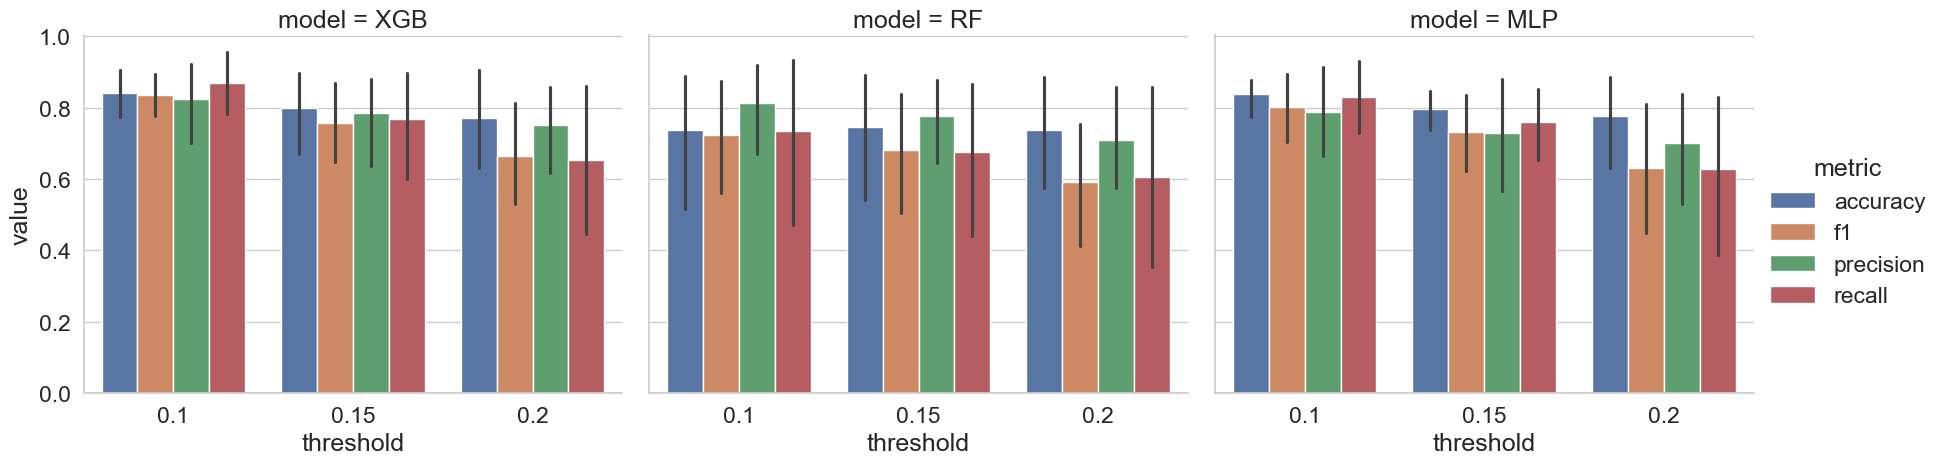

In [8]:
g = sns.catplot(
    data=metrics_melt_sp,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Equal Opportunity

In [9]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [10]:
metrics_eo = robustness(xgb_sp, rf_sp, mlp_sp, data, 'equal_opportunity')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

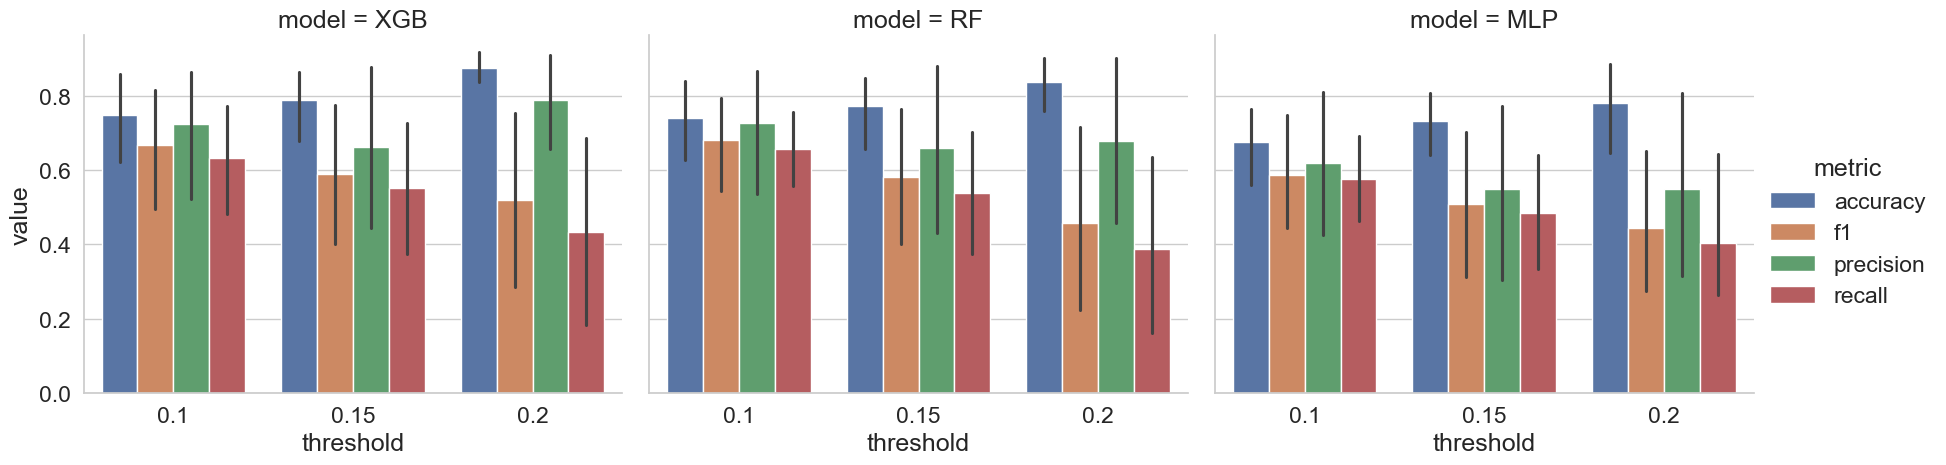

In [11]:
metrics_melt_eo = metrics_eo.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')
g = sns.catplot(
    data=metrics_melt_eo,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Average Odds

In [12]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [13]:
metrics_ao = robustness(xgb_sp, rf_sp, mlp_sp, data, 'average_odds')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [14]:
metrics_ao.groupby(['threshold', 'model']).mean()

unbalance_train  unbalance_test  accuracy        f1  \
threshold model                                                        
0.10      MLP           0.745709        2.233896  0.723862  0.629451   
          RF            0.745709        2.233896  0.625706  0.526168   
          XGB           0.745709        2.233896  0.664499  0.579716   
0.15      MLP           1.169295        2.864303  0.696849  0.550907   
          RF            1.169295        2.864303  0.714303  0.544449   
          XGB           1.169295        2.864303  0.708950  0.562379   
0.20      MLP           1.419523        3.499709  0.728798  0.559545   
          RF            1.419523        3.499709  0.752294  0.548974   
          XGB           1.419523        3.499709  0.756304  0.562927   

                 precision    recall  
threshold model                       
0.10      MLP     0.650333  0.636494  
          RF      0.620526  0.555283  
          XGB     0.618896  0.603959  
0.15      MLP     0.545059  0.580091  
          RF      0.625221  0.527272  
          XGB     0.612189  0.556799  
0.20      MLP     0.543248  0.599948  
          RF      0.656797  0.501814  
          XGB     0.649119  0.526731

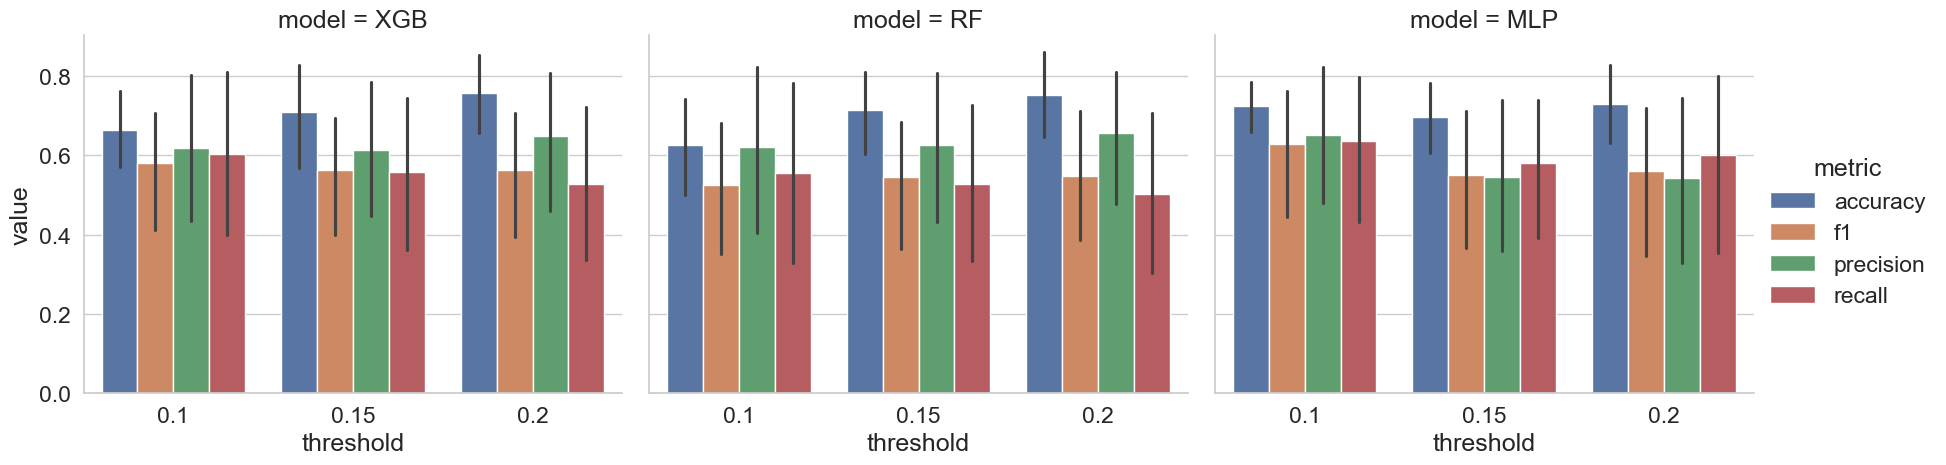

In [15]:
metrics_melt_ao = metrics_ao.melt(id_vars=['threshold', 'model'],
                                  value_vars=['accuracy', 'f1', 'precision', 'recall'],
                                  var_name='metric', value_name='value')
g = sns.catplot(
    data=metrics_melt_ao,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    kind='bar',
    height=5,
    aspect=1.2,
    sharey=True,
    col_wrap=3
)

## Full results

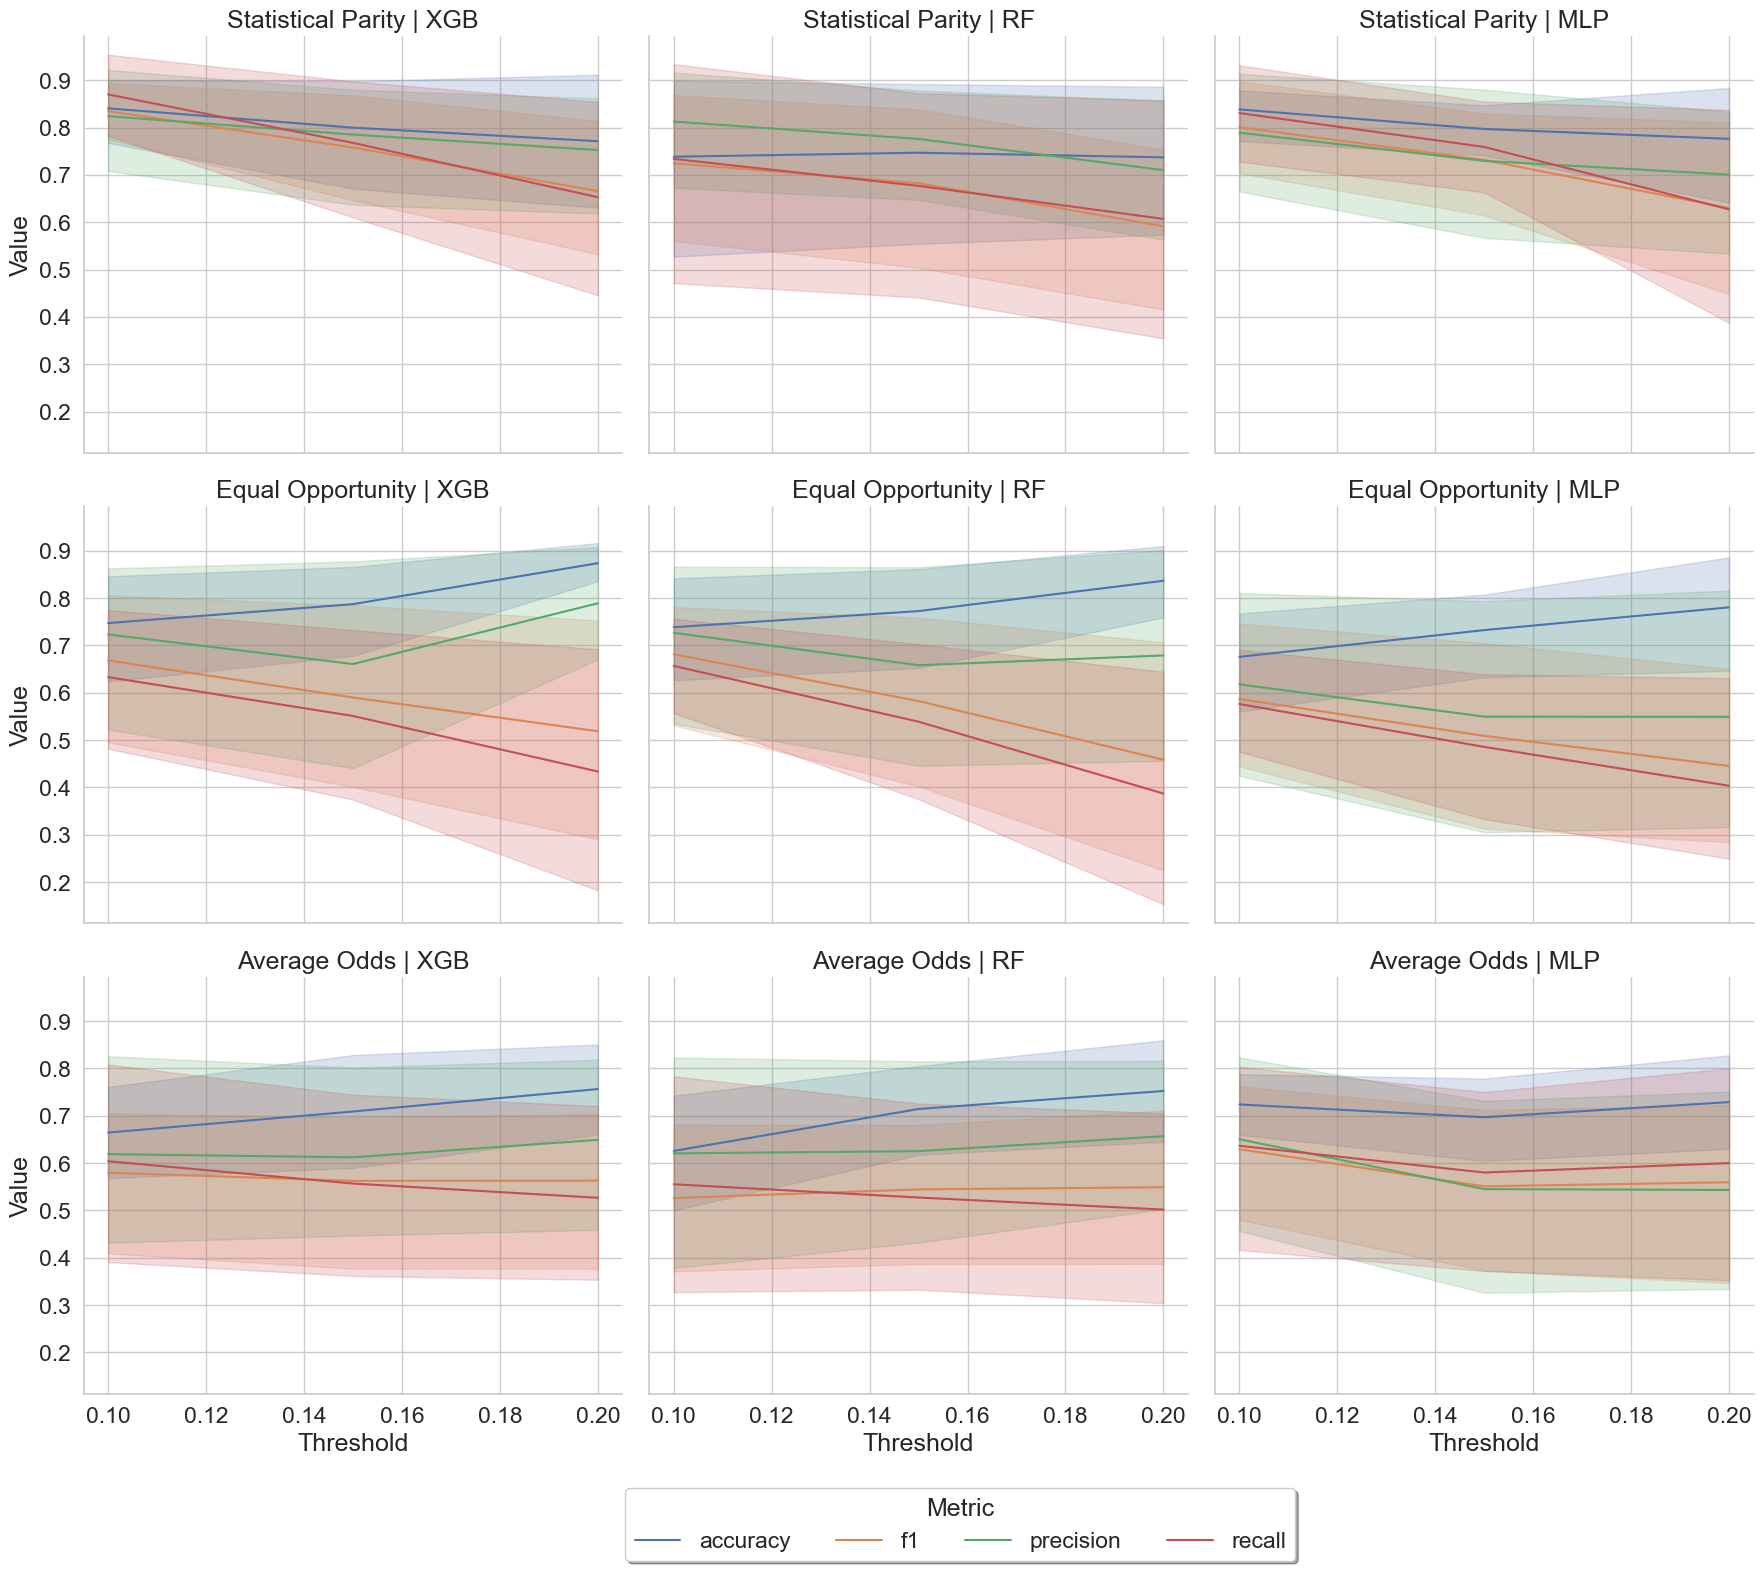

In [16]:
metrics_melt_sp['fairness'] = 'Statistical Parity'
metrics_melt_eo['fairness'] = 'Equal Opportunity'
metrics_melt_ao['fairness'] = 'Average Odds'
metrics_combined = pd.concat([metrics_melt_sp, metrics_melt_eo, metrics_melt_ao], ignore_index=True)

g = sns.relplot(
    data=metrics_combined,
    x='threshold',
    y='value',
    hue='metric',
    col='model',
    row='fairness',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
    markers=True,
    dashes=True
)

# g = sns.catplot(
#     data=metrics_combined,
#     x='threshold',
#     y='value',
#     hue='metric',
#     col='model',
#     row='fairness',
#     kind='bar',
#     height=4,
#     aspect=1.2,
#     sharey=True,
# )


# g.set_xticklabels(metrics_combined['threshold'].unique())

g.set_axis_labels("Threshold", "Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.06), ncol=4, title="Metric", frameon=True, shadow=True)
plt.savefig('imbalance.pdf', bbox_inches='tight')

## Wilcoxon Test

In [17]:
from pingouin import wilcoxon

In [28]:
def compute_tests(fairness, ref):
  sp_result = pd.DataFrame()
  for threshold in metrics_combined['threshold'].unique():
      if threshold != ref:
        for model in metrics_combined['model'].unique():
            for metric in metrics_combined['metric'].unique():
                subset = metrics_combined[(metrics_combined['threshold'] == threshold) &
                                          (metrics_combined['model'] == model) &
                                          (metrics_combined['metric'] == metric) &
                                          (metrics_combined['fairness'] == fairness)]['value']
                reference_threshold = metrics_combined[(metrics_combined['threshold'] == ref) &
                                          (metrics_combined['model'] == model) &
                                          (metrics_combined['metric'] == metric) &
                                          (metrics_combined['fairness'] == fairness)]['value']
                if not subset.empty:
                    print(f"Threshold: {threshold}, Model: {model}, Metric: {metric}")
                    print("Wilcoxon test results:")
                    print(wilcoxon(subset, reference_threshold, alternative='two-sided'))
                    print("\n")
                    sp_result = pd.concat([sp_result, pd.DataFrame({
                        'threshold': threshold,
                        'model': model,
                        'metric': metric,
                        'p_value': wilcoxon(subset, reference_threshold, alternative='two-sided')['p-val'].values[0],
                    }, index=[0])], ignore_index=True)
  return sp_result

### Statistical Parity


In [29]:
ref = 0.2
sp_results = compute_tests('Statistical Parity', ref)

Threshold: 0.1, Model: XGB, Metric: accuracy
Wilcoxon test results:
          W-val alternative   p-val       RBC  CLES
Wilcoxon    4.0   two-sided  0.4375  0.466667  0.56


Threshold: 0.1, Model: XGB, Metric: f1
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0   0.8


Threshold: 0.1, Model: XGB, Metric: precision
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0  0.72


Threshold: 0.1, Model: XGB, Metric: recall
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0   0.8


Threshold: 0.1, Model: RF, Metric: accuracy
Wilcoxon test results:
          W-val alternative  p-val       RBC  CLES
Wilcoxon    7.0   two-sided    1.0 -0.066667  0.48


Threshold: 0.1, Model: RF, Metric: f1
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0  0.68


Threshold: 0.

/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [30]:
sp_results

,threshold,model,metric,p_value
0,0.10,XGB,accuracy,0.437500
1,0.10,XGB,f1,0.062500
2,0.10,XGB,precision,0.062500
3,0.10,XGB,recall,0.062500
4,0.10,RF,accuracy,1.000000
5,0.10,RF,f1,0.062500
6,0.10,RF,precision,0.062500
7,0.10,RF,recall,0.062500
8,0.10,MLP,accuracy,0.437500
9,0.10,MLP,f1,0.062500


## Equal Opportunity

In [32]:
ref = 0.1
eo_results = compute_tests('Equal Opportunity', ref)
eo_results

Threshold: 0.15, Model: XGB, Metric: accuracy
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0  0.64


Threshold: 0.15, Model: XGB, Metric: f1
Wilcoxon test results:
          W-val alternative   p-val       RBC  CLES
Wilcoxon    2.0   two-sided  0.1875 -0.733333   0.4


Threshold: 0.15, Model: XGB, Metric: precision
Wilcoxon test results:
          W-val alternative   p-val       RBC  CLES
Wilcoxon    4.0   two-sided  0.4375 -0.466667  0.48


Threshold: 0.15, Model: XGB, Metric: recall
Wilcoxon test results:
          W-val alternative  p-val       RBC  CLES
Wilcoxon    1.0   two-sided  0.125 -0.866667   0.4


Threshold: 0.15, Model: RF, Metric: accuracy
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625  1.0  0.72


Threshold: 0.15, Model: RF, Metric: f1
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    3.0   two-sided  0.3125 -0.6  0.44

,threshold,model,metric,p_value
0,0.15,XGB,accuracy,0.0625
1,0.15,XGB,f1,0.1875
2,0.15,XGB,precision,0.4375
3,0.15,XGB,recall,0.1250
4,0.15,RF,accuracy,0.0625
5,0.15,RF,f1,0.3125
6,0.15,RF,precision,0.3125
7,0.15,RF,recall,0.0625
8,0.15,MLP,accuracy,0.1250
9,0.15,MLP,f1,0.1875


## Average Odds

In [34]:
ref = 0.15
ao_results = compute_tests('Average Odds', ref)
ao_results

Threshold: 0.1, Model: XGB, Metric: accuracy
Wilcoxon test results:
          W-val alternative  p-val       RBC  CLES
Wilcoxon    1.0   two-sided  0.125 -0.866667   0.4


Threshold: 0.1, Model: XGB, Metric: f1
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    6.0   two-sided  0.8125  0.2  0.52


Threshold: 0.1, Model: XGB, Metric: precision
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    6.0   two-sided  0.8125 -0.2  0.48


Threshold: 0.1, Model: XGB, Metric: recall
Wilcoxon test results:
          W-val alternative  p-val       RBC  CLES
Wilcoxon    1.0   two-sided  0.125  0.866667   0.6


Threshold: 0.1, Model: RF, Metric: accuracy
Wilcoxon test results:
          W-val alternative   p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.0625 -1.0  0.32


Threshold: 0.1, Model: RF, Metric: f1
Wilcoxon test results:
          W-val alternative  p-val       RBC  CLES
Wilcoxon    7.0   two-sided    1.0  0.066667  0.52


Thresho

,threshold,model,metric,p_value
0,0.1,XGB,accuracy,0.1250
1,0.1,XGB,f1,0.8125
2,0.1,XGB,precision,0.8125
3,0.1,XGB,recall,0.1250
4,0.1,RF,accuracy,0.0625
5,0.1,RF,f1,1.0000
6,0.1,RF,precision,0.8125
7,0.1,RF,recall,0.6250
8,0.1,MLP,accuracy,0.4375
9,0.1,MLP,f1,0.1250


In [35]:
sp_results.to_latex('tables/sp_results.tex', index=False, float_format="%.3f")
eo_results.to_latex('tables/eo_results.tex', index=False, float_format="%.3f")
ao_results.to_latex('tables/ao_results.tex', index=False, float_format="%.3f")

In [37]:
full_table = pd.concat([sp_results, eo_results, ao_results], ignore_index=True, axis=1)

In [40]:
full_table.columns = ['SP Threshold', 'SP Model', 'SP Metric', 'SP p-value',
                       'EO Threshold', 'EO Model', 'EO Metric', 'EO p-value',
                       'AO Threshold', 'AO Model', 'AO Metric', 'AO p-value']
full_table.to_latex('tables/full_results_formatted.tex', index=False, float_format="%.3f")